# Cash Money Investments: A Quantitative Hedge Fund

In [5]:
!pip install yfinance
!pip install tensorflow
!pip install scipy


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


### Downloading the Data

In [1]:
import pandas as pd
import numpy as np
import scipy as sc
from scipy import optimize as sco
import seaborn as sns
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [11]:
tickers = ['SPY', 'VDE', 'VMIAX', 'VINAX', 'VUIAX', 'VHCIX', 'VFAIX',
           'VCR', 'VCSAX', 'VITAX', 'VOX', 'VGSLX']

# Download historical adjusted close prices
data = yf.download(tickers, start="2004-10-01", end="2025-03-31")['Close']

# Get the last trading day of each month
monthly_prices = data.resample('M').last()

# Calculate monthly returns
monthly_returns = monthly_prices.pct_change()
monthly_returns = monthly_returns.iloc[1:]

[*********************100%***********************]  12 of 12 completed
C:\Users\kristian.nordby\AppData\Local\Temp\ipykernel_45324\3611441138.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_prices = data.resample('M').last()


In [12]:
monthly_returns

Ticker,SPY,VCR,VCSAX,VDE,VFAIX,VGSLX,VHCIX,VINAX,VITAX,VMIAX,VOX,VUIAX
Date,,,,,,,,,,,,
2004-11-30,0.044517,0.053536,0.039479,0.075273,0.034847,0.041678,0.023206,0.067610,0.052445,0.091603,0.052652,0.043370
2004-12-31,0.030121,0.052639,0.038143,-0.028016,0.041712,0.045247,0.058728,0.031296,0.030800,0.013563,0.036161,0.027275
2005-01-31,-0.022421,-0.038796,0.013388,0.037397,-0.029695,-0.084342,-0.031449,-0.027490,-0.057309,-0.030404,-0.055374,0.015327
2005-02-28,0.020904,-0.000566,0.003669,0.165533,-0.002678,0.028750,0.027126,0.011380,0.003525,0.082701,0.018898,0.019792
2005-03-31,-0.018293,-0.008115,-0.005119,-0.027931,-0.035092,-0.014208,-0.003601,-0.000726,-0.023706,-0.034055,-0.027821,0.008327
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-30,0.059633,0.129334,0.054790,0.085247,0.113324,0.041914,0.008151,0.082949,0.068860,0.030886,0.048611,0.040570
2024-12-31,-0.024060,-0.000457,-0.049813,-0.088706,-0.058366,-0.082244,-0.063990,-0.084543,-0.000048,-0.111070,-0.000814,-0.079362
2025-01-31,0.026856,0.040253,0.018131,0.019125,0.065923,0.016626,0.067696,0.047801,-0.007980,0.050360,0.072793,0.028899


In [13]:
df = pd.read_csv("macro.csv")

df_percent = df.drop('date', axis=1).pct_change() * 100

df_percent['date'] = df['date']

cols = ['date'] + [col for col in df_percent if col != 'date']
df_percent = df_percent[cols]

df_percent = df_percent.drop(0)

macro_returns = df_percent.reset_index(drop=True)
macro_returns

C:\Users\kristian.nordby\AppData\Local\Temp\ipykernel_45324\454950559.py:3: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_percent = df.drop('date', axis=1).pct_change() * 100


,date,Heating Oil Inflation Adjusted,SP-Gold,Gold-Oil,VIX,FEDFUNDS,Housing Starts,SP500 PE,Lumber Prices,Sugar Prices,...,PPI Intermediate Materials,PPI Crude Materials for further processing,Industrial Production Total Index,Final Products,IP Business Equipment,Resolving Consumer Credit Owned,Nonresolving Consumer Credit Owned,Total Bank Credit,Fed Securities Held Outright,1mo commercial paper
0,2/1/1999,-1.562500,-3.315686,4.006165,2.808493,3.703704,-4.462243,-3.228128,-0.645954,-15.258856,...,-0.330033,-2.197802,0.579566,0.545076,0.817441,0.047341,1.158385,-0.259049,1.017474,0.000000
1,3/1/1999,36.507937,4.376073,-27.138910,-12.188569,1.050420,2.395210,3.879436,0.249927,-14.119608,...,0.248344,0.674157,0.212594,-0.167734,-0.022328,-0.050699,1.152178,0.559633,1.286428,0.416667
2,4/1/1999,2.325581,5.021786,-11.231326,-7.234394,-1.871102,-9.181287,-2.885726,-0.603518,-11.825732,...,0.660611,1.897321,0.222608,-0.019810,0.521946,0.098640,0.717846,0.369334,1.294228,-0.622407
3,5/1/1999,-13.636364,-0.317507,8.384503,11.610283,1.059322,3.734707,-2.497120,3.854643,-6.088363,...,0.246103,6.024096,0.612996,0.845755,1.059165,0.451274,0.898319,0.142402,1.369822,0.000000
4,6/1/1999,21.052632,11.549487,-17.478999,-9.838525,-0.419287,-3.227809,5.443855,11.170192,17.567503,...,0.327332,0.206612,-0.065427,-0.762382,-0.291192,1.059362,0.561018,0.696484,1.734162,3.340292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309,11/1/2024,-0.930233,9.536877,0.022111,-19.766832,-3.726708,-2.901786,5.730413,9.815657,-3.147311,...,0.064967,-0.002452,-0.246444,-0.203709,1.601900,-0.788323,0.139810,0.007084,-0.706770,-3.347280
310,12/1/2024,6.572770,-1.507494,-6.127852,-0.930661,-2.795699,16.934866,-2.499206,-2.898475,-6.202010,...,0.168018,2.921587,1.133561,1.123801,2.334542,-3.070509,-1.825366,0.191543,-0.501901,-2.597403
311,1/1/2025,5.286344,-3.672468,3.811735,5.656341,-4.203540,-10.812582,2.701851,0.181043,-6.829323,...,1.052375,5.813086,0.217324,0.660186,1.284589,0.497605,0.063953,-0.034807,-0.679153,-4.000000
312,2/1/2025,-6.276151,-3.488210,7.775357,1.219089,0.000000,9.772226,-1.424347,7.056182,6.339852,...,0.442378,0.911745,0.849995,0.800740,1.810989,0.009670,-0.025520,0.358382,-0.617971,-0.231481


In [14]:
vanguard_funds = {
    'VCR': 'Consumer Discretionary',
    'VCSAX': 'Consumer Staples',
    'VDE': 'Energy',
    'VFAIX': 'Financials',
    'VGSLX': 'Real Estate',
    'VHCIX': 'Health Care',
    'VINAX': 'Industrials',
    'VITAX': 'Information Technology',
    'VMIAX': 'Materials',
    'VOX': 'Communication Services',
    'VUIAX': 'Utilities',
}

monthly_returns.columns = ['S&P']+[name for name in vanguard_funds.values()]
monthly_returns.head()

,S&P,Consumer Discretionary,Consumer Staples,Energy,Financials,Real Estate,Health Care,Industrials,Information Technology,Materials,Communication Services,Utilities
Date,,,,,,,,,,,,
2004-11-30,0.044517,0.053536,0.039479,0.075273,0.034847,0.041678,0.023206,0.067610,0.052445,0.091603,0.052652,0.043370
2004-12-31,0.030121,0.052639,0.038143,-0.028016,0.041712,0.045247,0.058728,0.031296,0.030800,0.013563,0.036161,0.027275
2005-01-31,-0.022421,-0.038796,0.013388,0.037397,-0.029695,-0.084342,-0.031449,-0.027490,-0.057309,-0.030404,-0.055374,0.015327
2005-02-28,0.020904,-0.000566,0.003669,0.165533,-0.002678,0.028750,0.027126,0.011380,0.003525,0.082701,0.018898,0.019792
2005-03-31,-0.018293,-0.008115,-0.005119,-0.027931,-0.035092,-0.014208,-0.003601,-0.000726,-0.023706,-0.034055,-0.027821,0.008327


In [15]:
macro_returns = macro_returns[69:]

In [16]:
len(macro_returns), len(monthly_returns)

(245, 245)

In [17]:
import pandas as pd



monthly_returns_reset = monthly_returns.reset_index()

macro_returns['Date'] = pd.to_datetime(macro_returns['date'], format='%m/%d/%Y')
monthly_returns_reset['Date'] = pd.to_datetime(monthly_returns_reset['Date'], format='%Y-%m-%d')
macro_returns['Month_Year'] = macro_returns['Date'].dt.to_period('M')
monthly_returns_reset['Month_Year'] = monthly_returns_reset['Date'].dt.to_period('M')
merged_df = pd.merge(macro_returns, monthly_returns_reset, on='Month_Year', how='inner')

merged_df = merged_df.drop(columns=['Month_Year', 'Date_x']).rename(columns={'Date_y': 'Date'})
merged_df = merged_df.set_index('Date')
print(merged_df.head())

                 date  Heating Oil Inflation Adjusted   SP-Gold   Gold-Oil  \
Date                                                                         
2004-11-30  11/1/2004                       -4.545455 -0.613839  10.093189   
2004-12-31  12/1/2004                      -10.822511  2.616508  13.768003   
2005-01-31   1/1/2005                        8.252427  1.619610 -13.535800   
2005-02-28   2/1/2005                       11.659193  2.053270  -7.008969   
2005-03-31   3/1/2005                       10.040161 -4.389729  -4.168347   

                  VIX   FEDFUNDS  Housing Starts  SP500 PE  Lumber Prices  \
Date                                                                        
2004-11-30  -9.327397   7.386364      -13.996139  3.859464       3.872118   
2004-12-31  -8.231462  13.227513       14.590348  3.245678       4.763955   
2005-01-31   7.853052   4.672897        4.995103 -5.389175       8.085106   
2005-02-28 -12.866890  11.160714        2.938433  1.890377       8.7

C:\Users\kristian.nordby\AppData\Local\Temp\ipykernel_45324\601145317.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  macro_returns['Date'] = pd.to_datetime(macro_returns['date'], format='%m/%d/%Y')
C:\Users\kristian.nordby\AppData\Local\Temp\ipykernel_45324\601145317.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  macro_returns['Month_Year'] = macro_returns['Date'].dt.to_period('M')


In [18]:
merged_df

,date,Heating Oil Inflation Adjusted,SP-Gold,Gold-Oil,VIX,FEDFUNDS,Housing Starts,SP500 PE,Lumber Prices,Sugar Prices,...,Consumer Staples,Energy,Financials,Real Estate,Health Care,Industrials,Information Technology,Materials,Communication Services,Utilities
Date,,,,,,,,,,,,,,,,,,,,,
2004-11-30,11/1/2004,-4.545455,-0.613839,10.093189,-9.327397,7.386364,-13.996139,3.859464,3.872118,-3.322354,...,0.039479,0.075273,0.034847,0.041678,0.023206,0.067610,0.052445,0.091603,0.052652,0.043370
2004-12-31,12/1/2004,-10.822511,2.616508,13.768003,-8.231462,13.227513,14.590348,3.245678,4.763955,1.474838,...,0.038143,-0.028016,0.041712,0.045247,0.058728,0.031296,0.030800,0.013563,0.036161,0.027275
2005-01-31,1/1/2005,8.252427,1.619610,-13.535800,7.853052,4.672897,4.995103,-5.389175,8.085106,1.457736,...,0.013388,0.037397,-0.029695,-0.084342,-0.031449,-0.027490,-0.057309,-0.030404,-0.055374,0.015327
2005-02-28,2/1/2005,11.659193,2.053270,-7.008969,-12.866890,11.160714,2.938433,1.890377,8.713838,0.644180,...,0.003669,0.165533,-0.002678,0.028750,0.027126,0.011380,0.003525,0.082701,0.018898,0.019792
2005-03-31,3/1/2005,10.040161,-4.389729,-4.168347,12.105412,4.819277,-15.541459,-1.911936,-0.014417,-0.940742,...,-0.005119,-0.027931,-0.035092,-0.014208,-0.003601,-0.000726,-0.023706,-0.034055,-0.027821,0.008327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-30,11/1/2024,-0.930233,9.536877,0.022111,-19.766832,-3.726708,-2.901786,5.730413,9.815657,-3.147311,...,0.054790,0.085247,0.113324,0.041914,0.008151,0.082949,0.068860,0.030886,0.048611,0.040570
2024-12-31,12/1/2024,6.572770,-1.507494,-6.127852,-0.930661,-2.795699,16.934866,-2.499206,-2.898475,-6.202010,...,-0.049813,-0.088706,-0.058366,-0.082244,-0.063990,-0.084543,-0.000048,-0.111070,-0.000814,-0.079362
2025-01-31,1/1/2025,5.286344,-3.672468,3.811735,5.656341,-4.203540,-10.812582,2.701851,0.181043,-6.829323,...,0.018131,0.019125,0.065923,0.016626,0.067696,0.047801,-0.007980,0.050360,0.072793,0.028899


In [19]:
monthly_returns['Year'] = monthly_returns.reset_index()['Date'].apply(lambda x: int(str(x)[:4]))
monthly_returns

,S&P,Consumer Discretionary,Consumer Staples,Energy,Financials,Real Estate,Health Care,Industrials,Information Technology,Materials,Communication Services,Utilities,Year
Date,,,,,,,,,,,,,
2004-11-30,0.044517,0.053536,0.039479,0.075273,0.034847,0.041678,0.023206,0.067610,0.052445,0.091603,0.052652,0.043370,NaN
2004-12-31,0.030121,0.052639,0.038143,-0.028016,0.041712,0.045247,0.058728,0.031296,0.030800,0.013563,0.036161,0.027275,NaN
2005-01-31,-0.022421,-0.038796,0.013388,0.037397,-0.029695,-0.084342,-0.031449,-0.027490,-0.057309,-0.030404,-0.055374,0.015327,NaN
2005-02-28,0.020904,-0.000566,0.003669,0.165533,-0.002678,0.028750,0.027126,0.011380,0.003525,0.082701,0.018898,0.019792,NaN
2005-03-31,-0.018293,-0.008115,-0.005119,-0.027931,-0.035092,-0.014208,-0.003601,-0.000726,-0.023706,-0.034055,-0.027821,0.008327,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-30,0.059633,0.129334,0.054790,0.085247,0.113324,0.041914,0.008151,0.082949,0.068860,0.030886,0.048611,0.040570,NaN
2024-12-31,-0.024060,-0.000457,-0.049813,-0.088706,-0.058366,-0.082244,-0.063990,-0.084543,-0.000048,-0.111070,-0.000814,-0.079362,NaN
2025-01-31,0.026856,0.040253,0.018131,0.019125,0.065923,0.016626,0.067696,0.047801,-0.007980,0.050360,0.072793,0.028899,NaN


In [20]:
merged_df.columns[-12:]

Index(['S&P', 'Consumer Discretionary', 'Consumer Staples', 'Energy',
       'Financials', 'Real Estate', 'Health Care', 'Industrials',
       'Information Technology', 'Materials', 'Communication Services',
       'Utilities'],
      dtype='object')

In [23]:
from sklearn.preprocessing import StandardScaler

values = merged_df.reset_index().drop(columns = ['Date','date']).astype(float).values
scaler = StandardScaler()
features = values[:,:-12]
labels = values[:,-12:]

In [24]:
features.shape, labels.shape

((245, 135), (245, 12))

### Testing the Baseline

In [25]:
errors = []
for row in range(1,labels.shape[0]-1):
    for returns, last_return in zip(labels[row], labels[row-1]):
        error = abs(returns - last_return)
        errors.append(error)
baseline_mae = sum(errors)/len(errors)
print(f"Baseline MAE: {round(baseline_mae*100,2)}%")

Baseline MAE: 5.69%


Our Baseline MAE is the MAE if we were to predict last month's returns for this month every time.

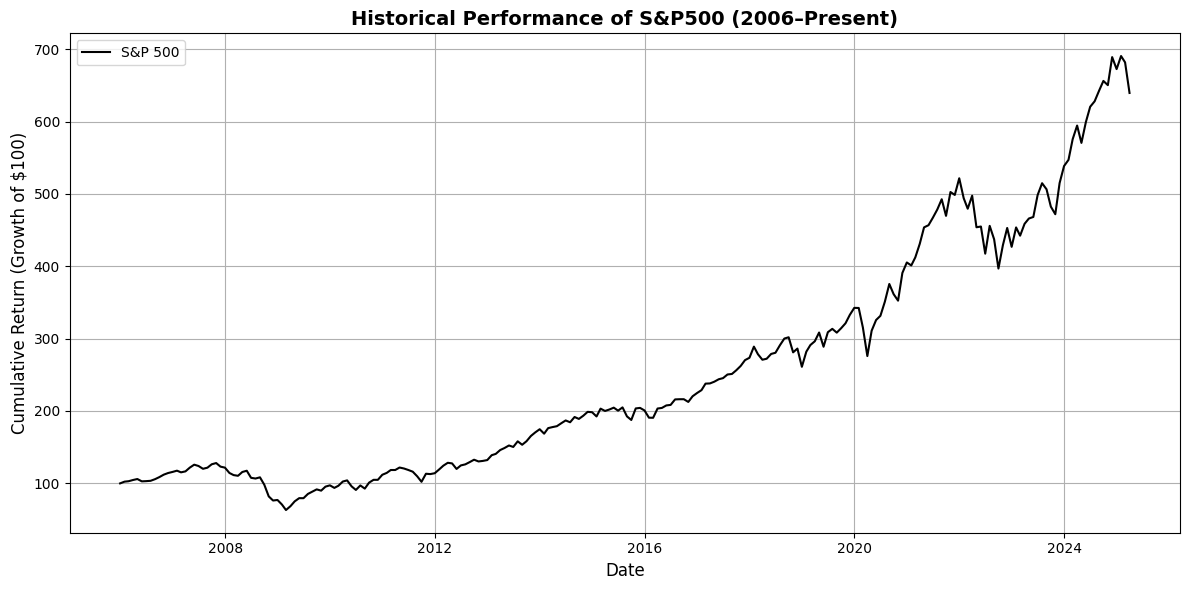

In [26]:
import matplotlib.pyplot as plt
sequence_length = 12
target_length = 1

sp = merged_df['S&P'].values[sequence_length+target_length:]

# Calculate cumulative returns (if not already)
initial_investment = 100
sp_cum = initial_investment * (1 + sp).cumprod()

# Create plot
plt.figure(figsize=(12, 6))
plt.plot(merged_df.index[sequence_length+target_length:], sp_cum, label='S&P 500', color='black', linewidth=1.5)

# Styling to match S&P performance plot
plt.title('Historical Performance of S&P500 (2006–Present)', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Return (Growth of $100)', fontsize=12)
plt.grid()  # Turn off grid if you want the clean look
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


Our benchmark comparison for the fund will be the S&P 500. This will be used primarily to demonstrate performance in terms of return of the fund, not error in prediction.

## Building the Model: LSTM

In [27]:
sequence_length = 12
num_features = features.shape[1]
target_length = 1
batch_size = 1
train_split = 0.80

X = []
Y = []

for i in range(len(labels) - sequence_length - target_length):
    inputs = features[i:i+sequence_length,:]
    targets = labels[i+sequence_length+target_length,:]

    X.append(inputs)
    Y.append(targets)


X = np.array(X)
Y = np.array(Y)

print(X.shape, Y.shape)

x_train = X[:int(train_split*len(X))]
y_train = Y[:int(train_split*len(Y))]
x_val = X[int(train_split*len(X)):]
y_val = Y[int(train_split*len(Y)):]

print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)
print("x_val shape: ", x_val.shape)
print("y_val shape: ", y_val.shape)


(232, 12, 135) (232, 12)
x_train shape:  (185, 12, 135)
y_train shape:  (185, 12)
x_val shape:  (47, 12, 135)
y_val shape:  (47, 12)


In [28]:
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU, Conv2D, Flatten, Bidirectional, GlobalMaxPooling1D, LayerNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.regularizers import l1, l2, l1_l2

model = Sequential([
    LSTM(1350, return_sequences=False, input_shape = (12, 135), recurrent_dropout = 0.8),
    LayerNormalization(),
    Dense(1280, kernel_regularizer=l1_l2(0.1), activation = 'leaky_relu'),
    Dense(512, kernel_regularizer=l1_l2(0.1), activation = 'leaky_relu'),
    Dense(160, kernel_regularizer=l1_l2(0.1), activation = 'leaky_relu'),
    Dense(12, kernel_regularizer=l2(0.1))
])

model.summary()

C:\Users\kristian.nordby\AppData\Local\miniconda3\envs\arcyber_cap\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 1350)                │       8,024,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization                  │ (None, 1350)                │           2,700 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1280)                │       1,729,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 160)                 │          82,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 12)                  │           1,932 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,496,264 (40.04 MB)

 Trainable params: 10,496,264 (40.04 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
model.compile(optimizer='adam', loss='mae', metrics=['mae'])

In [30]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = model.fit(x_train, y_train, validation_data = (x_val, y_val), epochs=5, callbacks=[early_stop], shuffle = True)

Epoch 1/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - loss: 5847.1279 - mae: 0.4111 - val_loss: 5040.4360 - val_mae: 0.2234
Epoch 2/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 807ms/step - loss: 4551.3984 - mae: 0.2148 - val_loss: 3857.0486 - val_mae: 0.1142
Epoch 3/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 707ms/step - loss: 3440.2781 - mae: 0.0882 - val_loss: 2852.1912 - val_mae: 0.0631
Epoch 4/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 807ms/step - loss: 2503.7051 - mae: 0.0461 - val_loss: 2016.5243 - val_mae: 0.0511
Epoch 5/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 859ms/step - loss: 1735.2338 - mae: 0.0386 - val_loss: 1349.2283 - val_mae: 0.0472


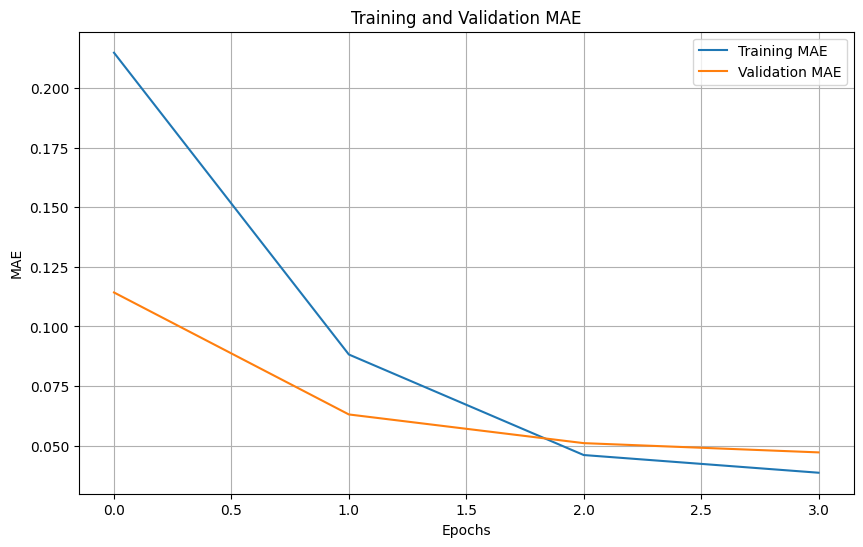

In [31]:
train_loss = history.history['mae'][1:]
val_loss = history.history['val_mae'][1:]

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training MAE')
plt.plot(val_loss, label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()

#### Evaluation (Backtesting through Historical Performance)

In [32]:
import numpy as np

def get_return_with_leverage(expected_returns, actual_returns, shrinkage=0, leverage_threshold=0.10, leverage_factor=10):
    """
    Compute the portfolio return with shrinkage and 5x leverage on sectors with expected return > 15%.
    
    Parameters:
        expected_returns (list of float): Expected return forecast for each sector (length = 12).
        actual_returns (list of float): Realized returns for each sector (length = 12).
        shrinkage (float): Shrinkage toward equal-weighted portfolio [0, 1].
        leverage_threshold (float): Expected return threshold to trigger leverage (default = 0.15).
        leverage_factor (float): Factor by which to lever sectors exceeding threshold (default = 5).
        
    Returns:
        float: Realized portfolio return accounting for allocation and leverage.
    """
    if len(expected_returns) != 12 or len(actual_returns) != 12:
        raise ValueError("Both expected_returns and actual_returns must be of length 12.")
    if not (0 <= shrinkage <= 1):
        raise ValueError("Shrinkage must be between 0 and 1.")

    # Step 1: Identify leveraged sectors
    leverage_flags = [r > leverage_threshold for r in expected_returns]
    
    # Step 2: Boost allocation weights (not returns) by leverage factor
    adjusted_weights = [
        leverage_factor if flag else 1 for flag in leverage_flags
    ]
    
    # Step 3: Apply expected return signals to determine tilt
    signal_strengths = [max(0, r) for r in expected_returns]  # directional confidence only
    raw_weights = [s * a for s, a in zip(signal_strengths, adjusted_weights)]

    total_raw = sum(raw_weights)
    if total_raw == 0:
        raw_weights = [1.0 / 12] * 12  # fallback to equal weight
    else:
        raw_weights = [w / total_raw for w in raw_weights]

    # Step 4: Shrink toward equal-weighted
    equal_weights = [1.0 / 12] * 12
    final_weights = [
        shrinkage * eq + (1 - shrinkage) * rw
        for eq, rw in zip(equal_weights, raw_weights)
    ]

    # Step 5: Calculate total capital deployed (can exceed 1.0 due to leverage)
    capital_deployed = sum([
        w * (leverage_factor if flag else 1)
        for w, flag in zip(final_weights, leverage_flags)
    ])

    # Step 6: Compute return, adjusting for leverage
    realized_return = sum([
        w * (leverage_factor if flag else 1) * r
        for w, r, flag in zip(final_weights, actual_returns, leverage_flags)
    ])

    # Net return as a percentage of capital deployed
    net_return = realized_return / capital_deployed

    return net_return


In [33]:
returns = []

for row in range(X.shape[0]):
    pred = model.predict(X[row,:,:].reshape(-1,12,135), verbose = 1).reshape(12,)
    returns.append(pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [34]:
roi = []
for i, row in enumerate(returns):
    roi.append(get_return_with_leverage(row, Y[i].reshape(12,)))

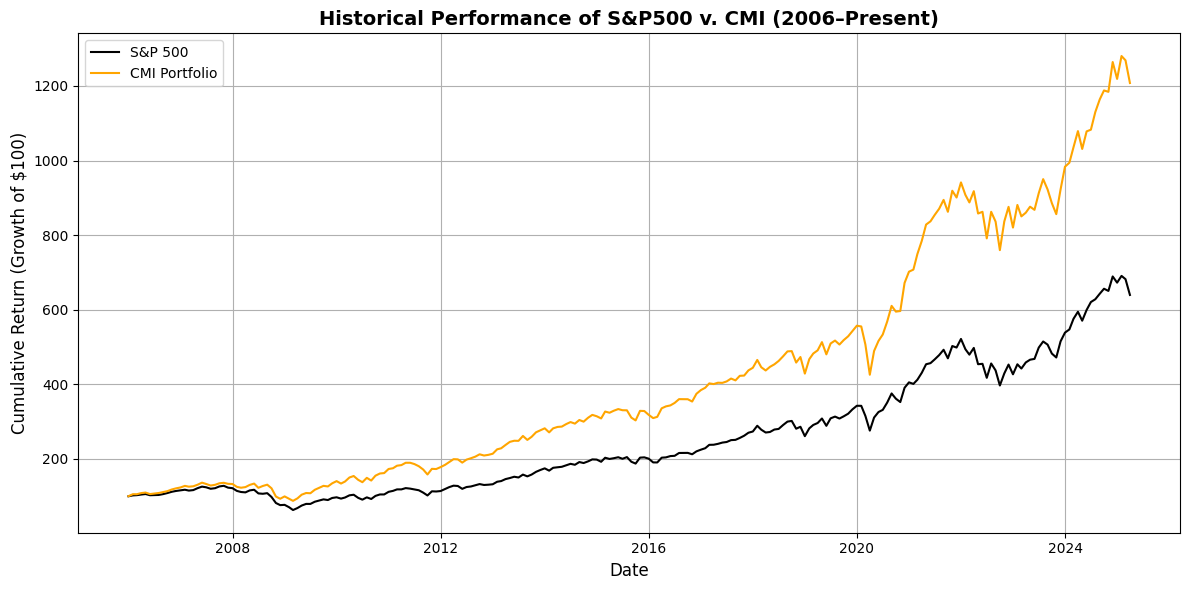

In [35]:
import matplotlib.pyplot as plt

sp = merged_df['S&P'].values[sequence_length+target_length:]
portfolio_return = np.array(roi)[:len(labels)-sequence_length-target_length]

# Calculate cumulative returns (if not already)
initial_investment = 100
sp_cum = initial_investment * (1 + sp).cumprod()
portfolio_cum = initial_investment * (1 + portfolio_return).cumprod()

# Create plot
plt.figure(figsize=(12, 6))
plt.plot(merged_df.index[sequence_length+target_length:], sp_cum, label='S&P 500', color='black', linewidth=1.5)
plt.plot(merged_df.index[sequence_length+target_length:], portfolio_cum, label='CMI Portfolio', color='orange', linewidth=1.5)

# Styling to match S&P performance plot
plt.title('Historical Performance of S&P500 v. CMI (2006–Present)', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Return (Growth of $100)', fontsize=12)
plt.grid()  # Turn off grid if you want the clean look
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


In [36]:
import numpy as np

def portfolio_metrics(returns, periods_per_year=12, risk_free_rate=0.0427):
    """
    Calculate Sortino Ratio, CAGR, and Standard Deviation from a numpy array of returns.

    Parameters:
    - returns: numpy array of periodic returns (e.g., monthly returns)
    - periods_per_year: number of periods per year (12 for monthly, 252 for daily)
    - risk_free_rate: annual risk-free rate (as decimal)

    Returns:
    - Dictionary with 'CAGR', 'Standard Deviation', and 'Sortino Ratio'
    """
    # Convert to numpy array
    returns = np.asarray(returns)

    # CAGR
    cumulative_return = np.prod(1 + returns)
    n_years = len(returns) / periods_per_year
    cagr = cumulative_return**(1 / n_years) - 1

    # Standard Deviation (annualized)
    std_dev = np.std(returns) * np.sqrt(periods_per_year)

    # Downside deviation (annualized)
    downside_returns = returns[returns < 0]
    downside_std = np.std(downside_returns) * np.sqrt(periods_per_year)

    # Sortino Ratio
    excess_cagr = cagr - risk_free_rate
    sortino_ratio = excess_cagr / downside_std if downside_std != 0 else np.nan

    return {
        'CAGR': round(cagr, 3),
        'Standard Deviation': round(std_dev, 3),
        'Sortino Ratio': round(sortino_ratio, 4)
    }

In [37]:
print("LSTM Portfolio: ")
print(portfolio_metrics(portfolio_return))

print("SP500: ")
print(portfolio_metrics(sp))

LSTM Portfolio: 
{'CAGR': np.float64(0.138), 'Standard Deviation': np.float64(0.155), 'Sortino Ratio': np.float64(0.8277)}
SP500: 
{'CAGR': np.float64(0.101), 'Standard Deviation': np.float64(0.152), 'Sortino Ratio': np.float64(0.5213)}


In [38]:
val_returns = []

for row in range(x_val.shape[0]):
    pred = model.predict(x_val[row,:,:].reshape(-1,12,135), verbose = 1).reshape(12,)
    val_returns.append(pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [39]:
val_roi = []
for i, row in enumerate(val_returns):
    val_roi.append(get_return_with_leverage(row, y_val[i].reshape(12,)))

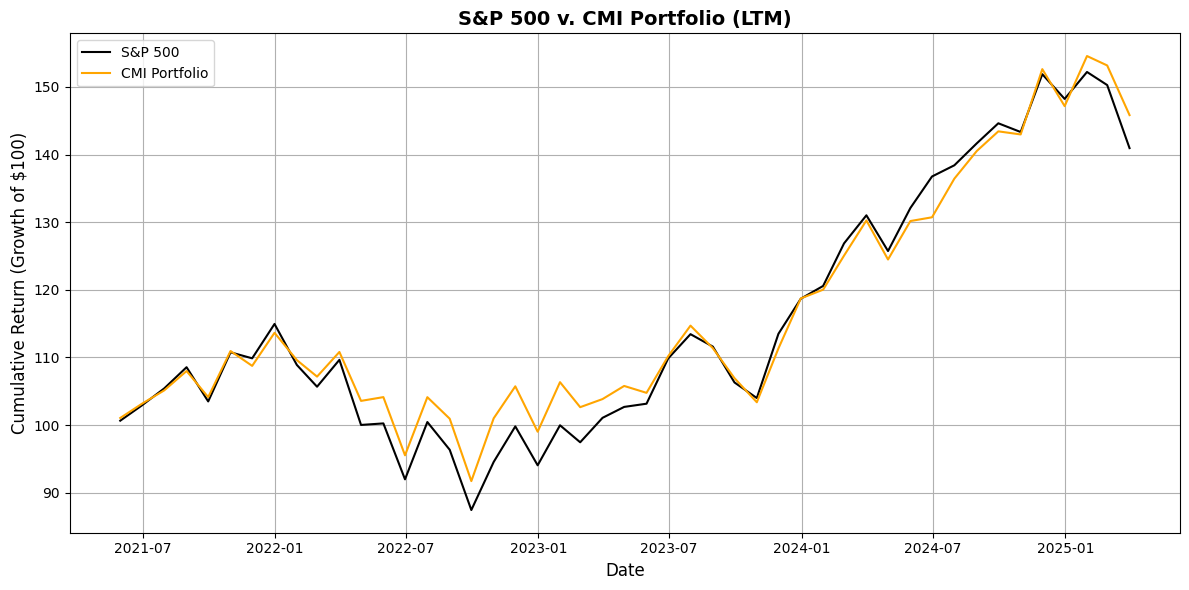

In [40]:
import matplotlib.pyplot as plt


# sp = merged_df['S&P'].values[sequence_length+target_length:]
sp_val = sp[-len(x_val):]
portfolio_return = np.array(val_roi)

# Calculate cumulative returns (if not already)
initial_investment = 100
sp_cum = initial_investment * (1 + sp_val).cumprod()
portfolio_cum = initial_investment * (1 + portfolio_return).cumprod()

# Create plot
plt.figure(figsize=(12, 6))
plt.plot(merged_df.index[-len(x_val):], sp_cum, label='S&P 500', color='black', linewidth=1.5)
plt.plot(merged_df.index[-len(x_val):], portfolio_cum, label='CMI Portfolio', color='orange', linewidth=1.5)

# Styling to match S&P performance plot
plt.title('S&P 500 v. CMI Portfolio (LTM)', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Return (Growth of $100)', fontsize=12)
plt.grid()  # Turn off grid if you want the clean look
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [41]:
print("LSTM Portfolio: ")
print(portfolio_metrics(val_roi))

print("SP500: ")
print(portfolio_metrics(sp_val))

LSTM Portfolio: 
{'CAGR': np.float64(0.101), 'Standard Deviation': np.float64(0.16), 'Sortino Ratio': np.float64(0.7357)}
SP500: 
{'CAGR': np.float64(0.092), 'Standard Deviation': np.float64(0.163), 'Sortino Ratio': np.float64(0.5459)}


### Building a Ridge Regression Model

In [42]:
features.shape, labels.shape

((245, 135), (245, 12))

In [43]:
val_index = int(0.8*len(features))

x_train_ridge = features[:val_index]
y_train_ridge = labels[1:val_index+1]
x_val_ridge = features[val_index:-1]
y_val_ridge = labels[val_index+1:]

In [44]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error as MAE
import numpy as np

ridge = Ridge()

param_grid = {
    'alpha': [5,25,50,300,500,1000]
}
grid_search = GridSearchCV(estimator=ridge,
                           param_grid=param_grid,
                           scoring='neg_mean_squared_error',
                           cv=5,
                           n_jobs=-1)

grid_search.fit(x_train_ridge, y_train_ridge)
best_ridge = grid_search.best_estimator_
best_alpha = grid_search.best_params_['alpha']

y_val_pred = best_ridge.predict(x_val_ridge)
val_mse = MAE(y_val_ridge, y_val_pred)
print(f"Best alpha: {best_alpha}")
print(f"Validation MSE: {val_mse:.4f}")

Best alpha: 1000
Validation MSE: 0.0506


Prediction of Returns (across all sectors) on the Validation Set

In [45]:
ridge_preds = best_ridge.predict(x_val_ridge)

In [46]:
from sklearn.metrics import mean_absolute_error as MAE

ridge_mae = MAE(y_val_ridge, ridge_preds)
print(f"MAE for Ridge Predictions: {ridge_mae*100}%")

MAE for Ridge Predictions: 5.056082674306273%


In [47]:
ridge_predictions = best_ridge.predict(features[:-1,:])
ridge_labels = labels[1:]

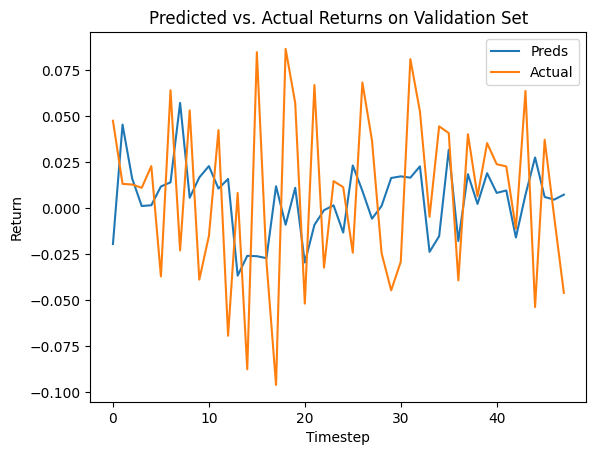

In [48]:
plt.plot(ridge_preds.mean(axis=1))
plt.plot(y_val_ridge.mean(axis=1))
plt.legend(['Preds','Actual'])
plt.title("Predicted vs. Actual Returns on Validation Set")
plt.xlabel("Timestep")
plt.ylabel("Return")
plt.show()

In [49]:
alltime_ridge_preds = best_ridge.predict(features)

returns = []
for i, row in enumerate(alltime_ridge_preds[:-1]):
    returns.append(get_return_with_leverage(row, labels[1+i]))

In [50]:
np.array(returns).std()*12

np.float64(0.5956628430041007)

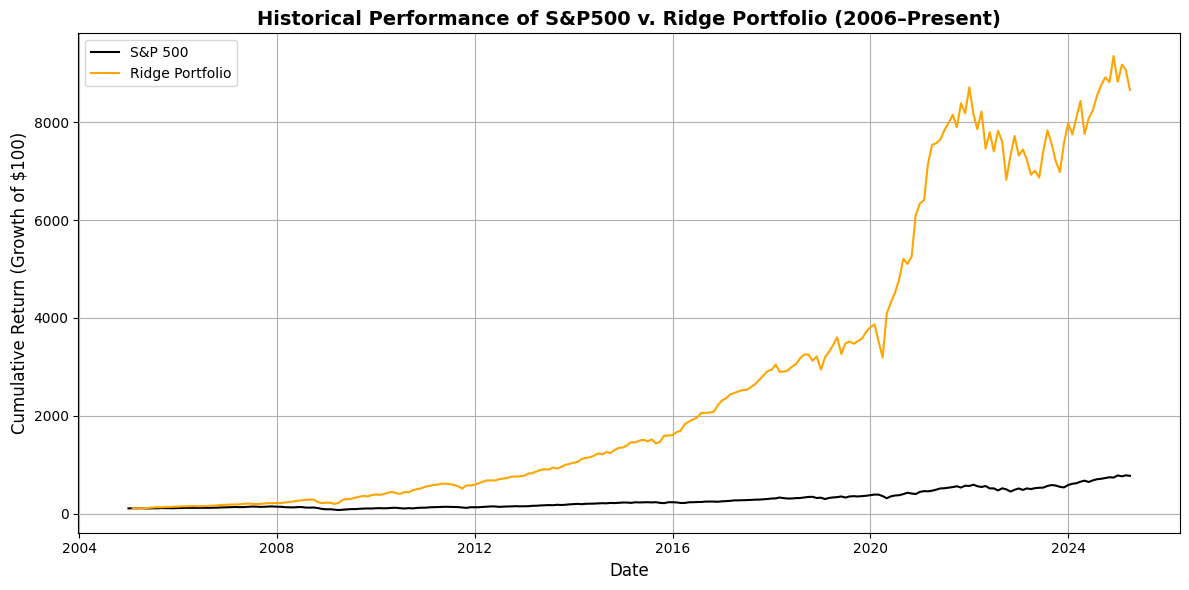

In [51]:
import matplotlib.pyplot as plt

sp = merged_df['S&P'].values[:(len(returns))]
portfolio_return = np.array(returns)

# Calculate cumulative returns (if not already)
initial_investment = 100
sp_cum = initial_investment * (1 + sp).cumprod()
portfolio_cum = initial_investment * (1 + portfolio_return).cumprod()

# Create plot
plt.figure(figsize=(12, 6))
plt.plot(merged_df.iloc[-len(returns):].index, sp_cum, label='S&P 500', color='black', linewidth=1.5)
plt.plot(merged_df.iloc[-len(returns)+1:].index, portfolio_cum[1:], label='Ridge Portfolio', color='orange', linewidth=1.5)

# Styling to match S&P performance plot
plt.title('Historical Performance of S&P500 v. Ridge Portfolio (2006–Present)', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Return (Growth of $100)', fontsize=12)
plt.grid() 
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


In [52]:
print("Ridge Portfolio: ")
print(portfolio_metrics(portfolio_return))

print("SP500: ")
print(portfolio_metrics(sp))

Ridge Portfolio: 
{'CAGR': np.float64(0.245), 'Standard Deviation': np.float64(0.172), 'Sortino Ratio': np.float64(1.6987)}
SP500: 
{'CAGR': np.float64(0.106), 'Standard Deviation': np.float64(0.149), 'Sortino Ratio': np.float64(0.5741)}


In [53]:
x_val_ridge.shape

(48, 135)

In [54]:
ridge_val_preds = best_ridge.predict(x_val_ridge)

returns = []
for i, row in enumerate(ridge_val_preds):
    returns.append(get_return_with_leverage(row, y_val_ridge[i]))

In [55]:
sp_val.shape, len(returns)

((47,), 48)

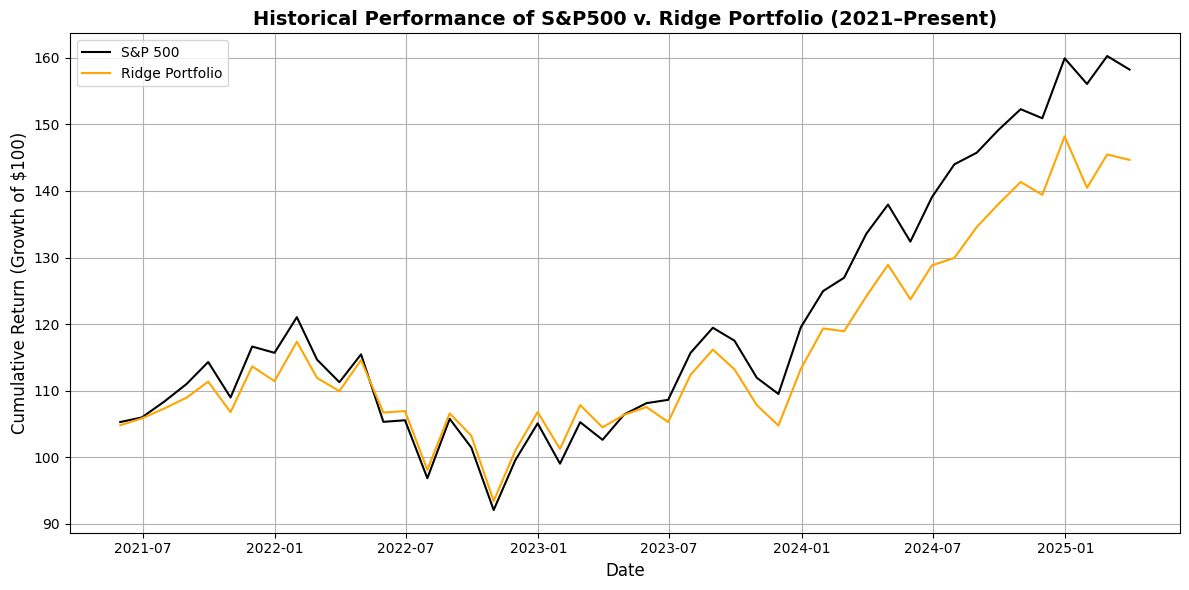

In [77]:
## CHATGPT - WROTE THIS CODE TO PLOT RETURNS OVER TIME

import matplotlib.pyplot as plt

portfolio_return = np.array(returns)[:-1]
sp_val = sp[-len(returns)+1:]
# Calculate cumulative returns (if not already)
initial_investment = 100
sp_cum = initial_investment * (1 + sp_val).cumprod()
portfolio_cum = initial_investment * (1 + portfolio_return).cumprod()

# Create plot
plt.figure(figsize=(12, 6))
plt.plot(merged_df.iloc[-len(returns)+1:].index, sp_cum, label='S&P 500', color='black', linewidth=1.5)
plt.plot(merged_df.iloc[-len(returns)+1:].index, portfolio_cum, label='Ridge Portfolio', color='orange', linewidth=1.5)

# Styling to match S&P performance plot
plt.title('Historical Performance of S&P500 v. Ridge Portfolio (2021–Present)', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Return (Growth of $100)', fontsize=12)
plt.grid() 
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [78]:
print("Ridge Portfolio: ")
print(portfolio_metrics(portfolio_return))

print("SP500: ")
print(portfolio_metrics(sp_val))

Ridge Portfolio: 
{'CAGR': np.float64(0.099), 'Standard Deviation': np.float64(0.157), 'Sortino Ratio': np.float64(0.6746)}
SP500: 
{'CAGR': np.float64(0.124), 'Standard Deviation': np.float64(0.16), 'Sortino Ratio': np.float64(0.9011)}


### Building a Model with a Decision Tree Classifier

In [58]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor()
param_grid = {
    'max_depth': [3, 5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8]
}

grid_search_tree = GridSearchCV(estimator=tree,
                                param_grid=param_grid,
                                scoring='neg_mean_squared_error',
                                cv=5,
                                n_jobs=-1)

grid_search_tree.fit(x_train_ridge, y_train_ridge)
best_tree = grid_search_tree.best_estimator_
best_params = grid_search_tree.best_params_

y_val_pred_tree = best_tree.predict(x_val_ridge)
val_mse_tree = MAE(y_val_ridge, y_val_pred_tree)
print(f"Best params: {best_params}")
print(f"Validation MAE: {val_mse_tree:.4f}")

Best params: {'max_depth': 3, 'min_samples_leaf': 8, 'min_samples_split': 20}
Validation MAE: 0.0487


In [59]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

tree = DecisionTreeRegressor(min_samples_split = 10, max_leaf_nodes = 50)
tree.fit(x_train_ridge, y_train_ridge)

,criterion,'squared_error'
,splitter,'best'
,max_depth,None
,min_samples_split,10
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,50
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [60]:
tree_val_preds = best_tree.predict(x_val_ridge)

MAE(y_val_ridge, tree_val_preds)

0.04873046084424661

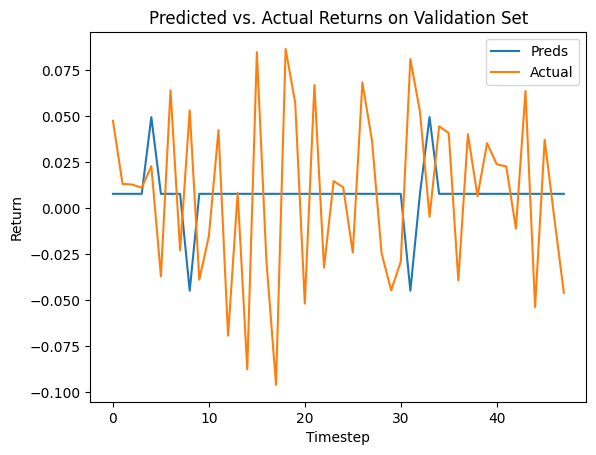

In [61]:
plt.plot(tree_val_preds.mean(axis=1))
plt.plot(y_val_ridge.mean(axis=1))
plt.legend(['Preds','Actual'])
plt.title("Predicted vs. Actual Returns on Validation Set")
plt.xlabel("Timestep")
plt.ylabel("Return")
plt.show()

In [62]:
alltime_tree_preds = best_tree.predict(features)

returns = []
for i, row in enumerate(alltime_tree_preds[:-1]):
    returns.append(get_return_with_leverage(row, labels[i]))

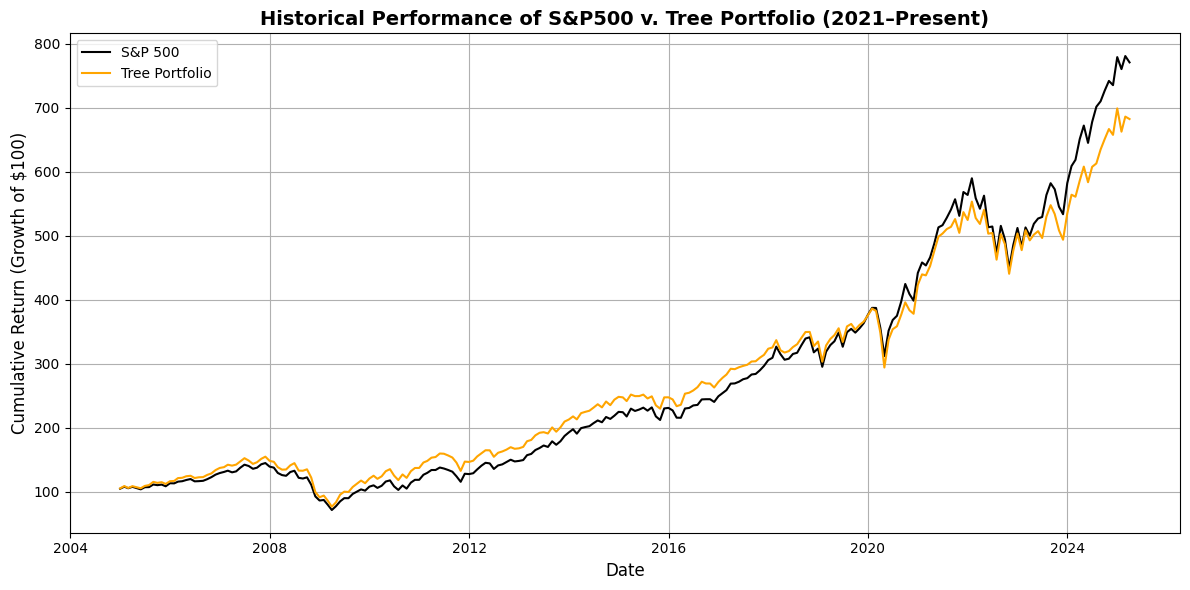

In [63]:
import matplotlib.pyplot as plt

portfolio_return = np.array(returns)
sp_val = sp[-len(returns):]
# Calculate cumulative returns (if not already)
initial_investment = 100
sp_cum = initial_investment * (1 + sp_val).cumprod()
portfolio_cum = initial_investment * (1 + portfolio_return).cumprod()

# Create plot
plt.figure(figsize=(12, 6))
plt.plot(merged_df.iloc[-len(returns):].index, sp_cum, label='S&P 500', color='black', linewidth=1.5)
plt.plot(merged_df.iloc[-len(returns):].index, portfolio_cum, label='Tree Portfolio', color='orange', linewidth=1.5)

# Styling to match S&P performance plot
plt.title('Historical Performance of S&P500 v. Tree Portfolio (2021–Present)', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Return (Growth of $100)', fontsize=12)
plt.grid() 
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [64]:
print("Tree Portfolio: ")
print(portfolio_metrics(portfolio_return))

print("SP500: ")
print(portfolio_metrics(sp))

Tree Portfolio: 
{'CAGR': np.float64(0.099), 'Standard Deviation': np.float64(0.155), 'Sortino Ratio': np.float64(0.4744)}
SP500: 
{'CAGR': np.float64(0.106), 'Standard Deviation': np.float64(0.149), 'Sortino Ratio': np.float64(0.5741)}


In [65]:
tree_val_preds = best_tree.predict(x_val_ridge)

returns = []
for i, row in enumerate(tree_val_preds):
    returns.append(get_return_with_leverage(row, y_val_ridge[i]))

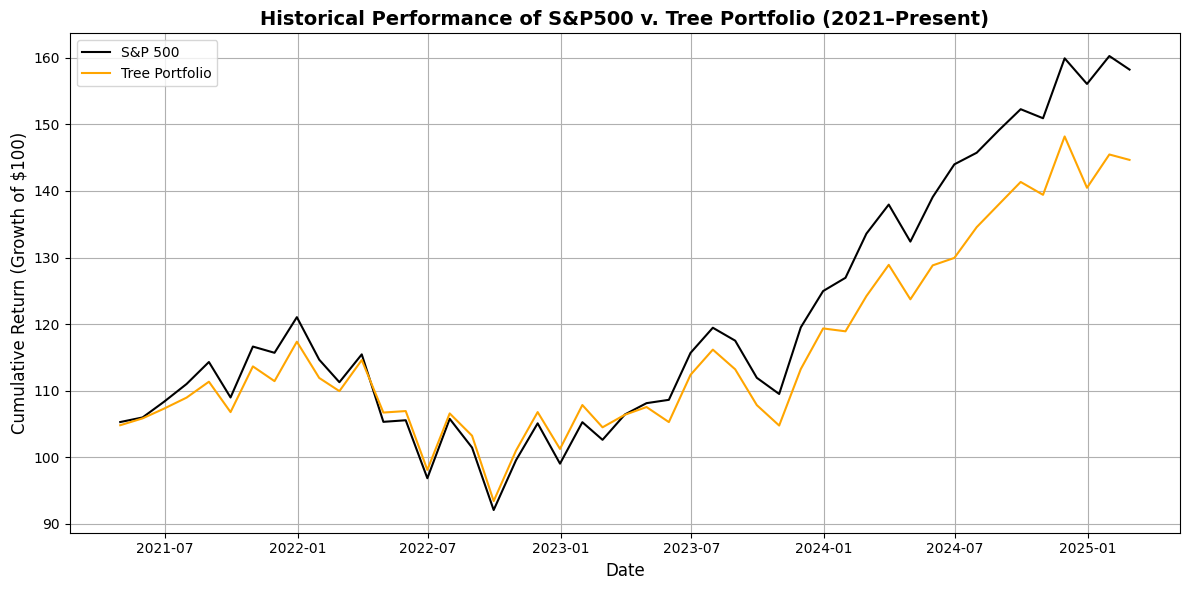

In [66]:
import matplotlib.pyplot as plt

portfolio_return = np.array(returns)
sp_val = sp[-len(returns)+1:]
# Calculate cumulative returns (if not already)
initial_investment = 100
sp_cum = initial_investment * (1 + sp_val).cumprod()
portfolio_cum = initial_investment * (1 + portfolio_return).cumprod()[:-1]

# Create plot
plt.figure(figsize=(12, 6))
plt.plot(merged_df.iloc[-len(returns):-1].index, sp_cum, label='S&P 500', color='black', linewidth=1.5)
plt.plot(merged_df.iloc[-len(returns):-1].index, portfolio_cum, label='Tree Portfolio', color='orange', linewidth=1.5)

# Styling to match S&P performance plot
plt.title('Historical Performance of S&P500 v. Tree Portfolio (2021–Present)', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Return (Growth of $100)', fontsize=12)
plt.grid() 
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [67]:
print("Tree Portfolio: ")
print(portfolio_metrics(portfolio_return))

print("SP500: ")
print(portfolio_metrics(sp_val))

Tree Portfolio: 
{'CAGR': np.float64(0.083), 'Standard Deviation': np.float64(0.158), 'Sortino Ratio': np.float64(0.4998)}
SP500: 
{'CAGR': np.float64(0.124), 'Standard Deviation': np.float64(0.16), 'Sortino Ratio': np.float64(0.9011)}


### Works Cited

ChatGPT, chatgpt.com. Assistance given to the author, code generation. Chatgpt helped us to make all of the plots for plotting return for each fund. ChatGPT also created our strategy function given extensive instruction. ChatGPT also helped with hyperparameter tuning, given my original code, and was told to debug my parameter grid dictionary. West Point, NY 02MAY2025.